# Main Code from repo https://github.com/aimacode/aima-python/blob/master/mdp.ipynb

## Markov Decision Processes (Chapter 17)



First we define an MDP, and the special case of a GridMDP, in which states are laid out in a 2-dimensional grid. We also represent a policy
as a dictionary of {state: action} pairs, and a Utility function as a dictionary of {state: number} pairs. We then define the value_iteration
and policy_iteration algorithms.

In [1]:
import random
from collections import defaultdict
import numpy as np
from utils import vector_add, orientations, turn_right, turn_left

## MDP

In [41]:
class MDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. [Page 646]"""

    def __init__(self, init, actlist, terminals, transitions=None, reward=None, states=None, gamma=0.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        # collect states from transitions table if not passed.
        self.states = states #or self.get_states_from_transitions(transitions)

        self.init = init #is just the initial value which we can also just make randomly

        if isinstance(actlist, list):
            # if actlist is a list, all states have the same actions
            self.actlist = actlist

        elif isinstance(actlist, dict):
            # if actlist is a dict, different actions for each state
            self.actlist = actlist

        self.terminals = terminals
        self.transitions = transitions #or {}
        # if not self.transitions:
        #     print("Warning: Transition table is empty.")

        self.gamma = gamma

        self.reward = reward #or {s: 0 for s in self.states}

        # self.check_consistency()

    def R(self, state): #Reward Function
        """Return a numeric reward for this state."""

        return self.reward[state]
    
    #this one needs to be extended 

    def T(self, state, action): #Transition Function
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""

        if not self.transitions:
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Return a list of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""

        if state in self.terminals:
            return [None]
        else:
            return self.actlist

#this is just if the states were not passed but we'll make sure they are always passed

    # def get_states_from_transitions(self, transitions):
    #     if isinstance(transitions, dict):
    #         s1 = set(transitions.keys())
    #         s2 = set(tr[1] for actions in transitions.values()
    #                  for effects in actions.values()
    #                  for tr in effects)
    #         return s1.union(s2)
    #     else:
    #         print('Could not retrieve states from transitions')
    #         return None

    # def check_consistency(self):

    #     # check that all states in transitions are valid
    #     assert set(self.states) == self.get_states_from_transitions(self.transitions)

    #     # check that init is a valid state
    #     assert self.init in self.states

    #     # check reward for each state
    #     assert set(self.reward.keys()) == set(self.states)

    #     # check that all terminals are valid states
    #     assert all(t in self.states for t in self.terminals)

    #     # check that probability distributions for all actions sum to 1
    #     for s1, actions in self.transitions.items():
    #         for a in actions.keys():
    #             s = 0
    #             for o in actions[a]:
    #                 s += o[0]
    #             assert abs(s - 1) < 0.001

In [42]:
class MDP2(MDP):
    """
    Inherits from MDP. Handles terminal states, and transitions to and from terminal states better.
    """

    def __init__(self, init, actlist, terminals, transitions, reward=None, gamma=0.9):
        MDP.__init__(self, init, actlist, terminals, transitions, reward, gamma=gamma)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else:
            return self.transitions[state][action]

In [4]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
t = {
    "A": {
            "X": [(0.3, "A"), (0.7, "B")],
            "Y": [(1.0, "A")]
         },
    "B": {
            "X": {(0.8, "End"), (0.2, "B")},
            "Y": {(1.0, "A")}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

In [43]:
class CustomMDP(MDP):
    def __init__(self, init, terminals, transition_matrix, reward = None, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        MDP.__init__(self, init, actlist, terminals, transition_matrix, reward, gamma=gamma)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else: 
            return self.t[state][action]

In [44]:
our_mdp = CustomMDP(init, terminals, t, rewards, gamma=.9)

## GRID MDP

In [7]:
class GridMDP(MDP):

    """A two-dimensional grid MDP, as in [Figure 17.1]. All you have to do is
    specify the grid as a list of lists of rewards; use None for an obstacle
    (unreachable state). Also, you should specify the terminal states.
    An action is an (x, y) unit vector; e.g. (1, 0) means move east."""

    def __init__(self, grid, terminals, init=(0, 0), gamma=.9):
        grid.reverse()  # because we want row 0 on bottom, not on top
        reward = {}
        states = set()
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.grid = grid
        for x in range(self.cols):
            for y in range(self.rows):
                if grid[y][x] is not None:
                    states.add((x, y))
                    reward[(x, y)] = grid[y][x]
        self.states = states
        actlist = orientations
        transitions = {}
        for s in states:
            transitions[s] = {}
            for a in actlist:
                transitions[s][a] = self.calculate_T(s, a)
        MDP.__init__(self, init, actlist=actlist,
                     terminals=terminals, transitions = transitions, 
                     reward = reward, states = states, gamma=gamma)

    def calculate_T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, turn_right(action))),
                    (0.1, self.go(state, turn_left(action)))]
    
    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else:
            return self.transitions[state][action]
 
    def go(self, state, direction):
        """Return the state that results from going in this direction."""
        state1 = vector_add(state, direction)
        return state1 if state1 in self.states else state

    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""
        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {
            (1, 0): '>', (0, 1): '^', (-1, 0): '<', (0, -1): 'v', None: '.'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})

In [8]:
sequential_decision_environment = GridMDP([[-0.04, -0.04, -0.04, +1],
                                           [-0.04, None, -0.04, -1],
                                           [-0.04, -0.04, -0.04, -0.04]],
                                          terminals=[(3, 2), (3, 1)])

In [9]:
sequential_decision_environment


## Value Iteration

In [10]:
def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration. [Figure 17.4]"""

    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            U1[s] = R(s) + gamma * max(sum(p * U[s1] for (p, s1) in T(s, a))
                                       for a in mdp.actions(s))
            delta = max(delta, abs(U1[s] - U[s]))
        if delta <= epsilon * (1 - gamma) / gamma:
            return U





In [11]:
value_iteration(sequential_decision_environment)


{(0, 1): 0.3984432178350045,
 (1, 2): 0.649585681261095,
 (2, 1): 0.48644001739269643,
 (0, 0): 0.2962883154554812,
 (3, 1): -1.0,
 (2, 0): 0.3447542300124158,
 (3, 0): 0.12987274656746342,
 (0, 2): 0.5093943765842497,
 (2, 2): 0.7953620878466678,
 (1, 0): 0.25386699846479516,
 (3, 2): 1.0}

### Value Iteration Visualization

In [12]:
def value_iteration_instru(mdp, iterations=20):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

In [13]:
columns = 4
rows = 3
U_over_time = value_iteration_instru(sequential_decision_environment)

In [14]:
%matplotlib inline
from notebook import make_plot_grid_step_function

plot_grid_step = make_plot_grid_step_function(columns, rows, U_over_time)

In [15]:
import ipywidgets as widgets
from IPython.display import display
from notebook import make_visualize

iteration_slider = widgets.IntSlider(min=1, max=15, step=1, value=0)
w=widgets.interactive(plot_grid_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])
a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

interactive(children=(IntSlider(value=1, description='iteration', max=15, min=1), Output()), _dom_classes=('wi…

ValueError: cannot find widget or abbreviation for argument: 'visualize'

## Policy Iteration

In [16]:
def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action. [Equation 17.4]"""

    pi = {}
    for s in mdp.states:
        pi[s] = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
    return pi


def expected_utility(a, s, U, mdp):
    """The expected utility of doing a in state s, according to the MDP and U."""

    return sum(p * U[s1] for (p, s1) in mdp.T(s, a))

In [17]:
def policy_iteration(mdp):
    """Solve an MDP by policy iteration [Figure 17.7]"""

    U = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    while True:
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        for s in mdp.states:
            a = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            return pi


def policy_evaluation(pi, U, mdp, k=20):
    """Return an updated utility mapping U from each state in the MDP to its
    utility, using an approximation (modified policy iteration)."""

    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            U[s] = R(s) + gamma * sum(p * U[s1] for (p, s1) in T(s, pi[s]))
    return U

In [18]:
policy_iteration(sequential_decision_environment)


{(0, 1): (0, 1),
 (1, 2): (1, 0),
 (2, 1): (0, 1),
 (0, 0): (0, 1),
 (3, 1): None,
 (2, 0): (0, 1),
 (3, 0): (-1, 0),
 (0, 2): (1, 0),
 (2, 2): (1, 0),
 (1, 0): (1, 0),
 (3, 2): None}

## POMDP

In [45]:
class POMDP(MDP):
    """A Partially Observable Markov Decision Process, defined by
    a transition model P(s'|s,a), actions A(s), a reward function R(s),
    and a sensor model P(e|s). We also keep track of a gamma value,
    for use by algorithms. The transition and the sensor models
    are defined as matrices. We also keep track of the possible states
    and actions for each state. [Page 659]."""

    def __init__(self, actions, transitions=None, evidences=None, rewards=None, states=None, gamma=0.95):
        """Initialize variables of the pomdp"""

        if not (0 < gamma <= 1):
            raise ValueError('A POMDP must have 0 < gamma <= 1')

        self.states = states
        self.actions = actions

        # transition model cannot be undefined
        self.t_prob = transitions or {}
        if not self.t_prob:
            print('Warning: Transition model is undefined')

        # sensor model cannot be undefined
        self.e_prob = evidences or {}
        if not self.e_prob:
            print('Warning: Sensor model is undefined')

        self.gamma = gamma
        self.rewards = rewards

    def remove_dominated_plans(self, input_values):
        """
        Remove dominated plans.
        This method finds all the lines contributing to the
        upper surface and removes those which don't.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = [values[0]]
        y1_max = max(val[1] for val in values)
        tgt = values[0]
        prev_b = 0
        prev_ix = 0
        while tgt[1] != y1_max:
            min_b = 1
            min_ix = 0
            for i in range(prev_ix + 1, len(values)):
                if values[i][0] - tgt[0] + tgt[1] - values[i][1] != 0:
                    trans_b = (values[i][0] - tgt[0]) / (values[i][0] - tgt[0] + tgt[1] - values[i][1])
                    if 0 <= trans_b <= 1 and trans_b > prev_b and trans_b < min_b:
                        min_b = trans_b
                        min_ix = i
            prev_b = min_b
            prev_ix = min_ix
            tgt = values[min_ix]
            best.append(tgt)

        return self.generate_mapping(best, input_values)

    def remove_dominated_plans_fast(self, input_values):
        """
        Remove dominated plans using approximations.
        Resamples the upper boundary at intervals of 100 and
        finds the maximum values at these points.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = []
        sr = 100
        for i in range(sr + 1):
            x = i / float(sr)
            maximum = (values[0][1] - values[0][0]) * x + values[0][0]
            tgt = values[0]
            for value in values:
                val = (value[1] - value[0]) * x + value[0]
                if val > maximum:
                    maximum = val
                    tgt = value

            if all(any(tgt != v) for v in best):
                best.append(np.array(tgt))

        return self.generate_mapping(best, input_values)

    def generate_mapping(self, best, input_values):
        """Generate mappings after removing dominated plans"""

        mapping = defaultdict(list)
        for value in best:
            for action in input_values:
                if any(all(value == v) for v in input_values[action]):
                    mapping[action].append(value)

        return mapping

    def max_difference(self, U1, U2):
        """Find maximum difference between two utility mappings"""

        for k, v in U1.items():
            sum1 = 0
            for element in U1[k]:
                sum1 += sum(element)
            sum2 = 0
            for element in U2[k]:
                sum2 += sum(element)
        return abs(sum1 - sum2)


In [46]:
# transition probability P(s'|s,a)
t_prob = [[[0.9, 0.1], [0.1, 0.9]], [[0.1, 0.9], [0.9, 0.1]]]
# evidence function P(e|s)
e_prob = [[[0.6, 0.4], [0.4, 0.6]], [[0.6, 0.4], [0.4, 0.6]]]
# reward function
rewards = [[0.0, 0.0], [1.0, 1.0]]
# discount factor
gamma = 0.95
# actions
actions = ('0', '1')
# states
states = ('0', '1')

In [47]:
pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)


## POMDP Value Iteration 

In [48]:
class Matrix:
    """Matrix operations class"""

    @staticmethod
    def add(A, B):
        """Add two matrices A and B"""

        res = []
        for i in range(len(A)):
            row = []
            for j in range(len(A[0])):
                row.append(A[i][j] + B[i][j])
            res.append(row)
        return res

    @staticmethod
    def scalar_multiply(a, B):
        """Multiply scalar a to matrix B"""

        for i in range(len(B)):
            for j in range(len(B[0])):
                B[i][j] = a * B[i][j]
        return B

    @staticmethod
    def multiply(A, B):
        """Multiply two matrices A and B element-wise"""

        matrix = []
        for i in range(len(B)):
            row = []
            for j in range(len(B[0])):
                row.append(B[i][j] * A[j][i])
            matrix.append(row)

        return matrix

    @staticmethod
    def matmul(A, B):
        """Inner-product of two matrices"""

        return [[sum(ele_a * ele_b for ele_a, ele_b in zip(row_a, col_b)) for col_b in list(zip(*B))] for row_a in A]

    @staticmethod
    def transpose(A):
        """Transpose a matrix"""

        return [list(i) for i in zip(*A)]


In [49]:
def pomdp_value_iteration(pomdp, epsilon=0.1):
    """Solving a POMDP by value iteration."""

    U = {'':[[0]* len(pomdp.states)]}
    count = 0
    while True:
        count += 1
        prev_U = U
        values = [val for action in U for val in U[action]]
        value_matxs = []
        for i in values:
            for j in values:
                value_matxs.append([i, j])

        U1 = defaultdict(list)
        for action in pomdp.actions:
            for u in value_matxs:
                u1 = Matrix.matmul(Matrix.matmul(pomdp.t_prob[int(action)], Matrix.multiply(pomdp.e_prob[int(action)], Matrix.transpose(u))), [[1], [1]])
                u1 = Matrix.add(Matrix.scalar_multiply(pomdp.gamma, Matrix.transpose(u1)), [pomdp.rewards[int(action)]])
                U1[action].append(u1[0])

        U = pomdp.remove_dominated_plans_fast(U1)
        # replace with U = pomdp.remove_dominated_plans(U1) for accurate calculations
        
        if count > 10:
            if pomdp.max_difference(U, prev_U) < epsilon * (1 - pomdp.gamma) / pomdp.gamma:
                return U

In [50]:
# transition function P(s'|s,a)
t_prob = [[[0.65, 0.35], [0.65, 0.35]], [[0.65, 0.35], [0.65, 0.35]], [[1.0, 0.0], [0.0, 1.0]]]
# evidence function P(e|s)
e_prob = [[[0.5, 0.5], [0.5, 0.5]], [[0.5, 0.5], [0.5, 0.5]], [[0.8, 0.2], [0.3, 0.7]]] #here the evidence seems to already be predefined! How do we define it gradually? Or do I just predefine? 
# reward function
rewards = [[5, -10], [-20, 5], [-1, -1]]

gamma = 0.95
actions = ('0', '1', '2')
states = ('0', '1')

pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

In [51]:
utility = pomdp_value_iteration(pomdp, epsilon=0.1)


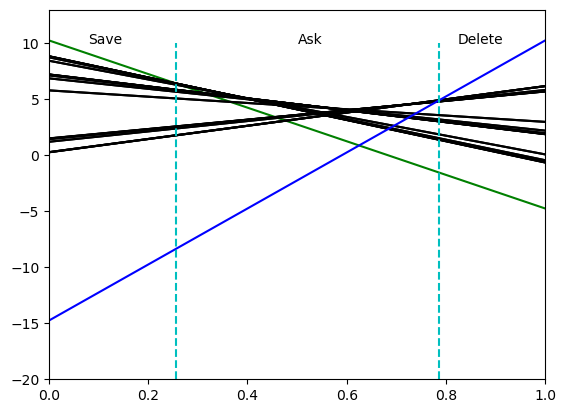

In [27]:
%matplotlib inline

from notebook import psource, pseudocode, plot_pomdp_utility
plot_pomdp_utility(utility)

## One Step